<a href="https://colab.research.google.com/github/Yuji-ONUKI/GCI2020_Winter/blob/main/June2_0500_simple_home_default_credit_lb_score_0_789.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

print('Importing data...')
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
data = pd.read_csv("/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2/input/train.csv")
test = pd.read_csv("/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2/input/test.csv")

#Separate target variable
y = data['TARGET']
del data['TARGET']

#Feature engineering
#data['loan_to_income'] = data.AMT_ANNUITY/data.AMT_INCOME_TOTAL
#test['loan_to_income'] = test.AMT_ANNUITY/test.AMT_INCOME_TOTAL

#One-hot encoding of categorical features in data and test sets
categorical_features = [col for col in data.columns if data[col].dtype == 'object']

one_hot_df = pd.concat([data,test])
one_hot_df = pd.get_dummies(one_hot_df, columns=categorical_features)

data = one_hot_df.iloc[:data.shape[0],:]
test = one_hot_df.iloc[data.shape[0]:,]



Importing data...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test = test[test.columns[data.isnull().mean() < 0.85]]
data = data[data.columns[data.isnull().mean() < 0.85]]

In [ ]:
data['FLAG_NOT_EMPLOYED']=0
data.loc[data['DAYS_EMPLOYED']==365243,'FLAG_NOT_EMPLOYED']=1
#data.loc[data['DAYS_EMPLOYED']==365243,'DAYS_EMPLOYED']=np.NAN
test['FLAG_NOT_EMPLOYED']=0
test.loc[test['DAYS_EMPLOYED']==365243,'FLAG_NOT_EMPLOYED']=1
#test.loc[test['DAYS_EMPLOYED']==365243,'DAYS_EMPLOYED']=np.NAN

In [ ]:
data['YEARS_BIRTH']=round(data['DAYS_BIRTH']/365)
test['YEARS_BIRTH']=round(test['DAYS_BIRTH']/365)

data['YEARS_ID_PUBLISH']=round(data['DAYS_ID_PUBLISH']/365)
test['YEARS_ID_PUBLISH']=round(test['DAYS_ID_PUBLISH']/365)

data['YEARS_REGISTRATION']=round(data['DAYS_REGISTRATION']/365)
test['YEARS_REGISTRATION']=round(test['DAYS_REGISTRATION']/365)


data['YEARS_EMPLOYED']=round(data['DAYS_EMPLOYED']/365)
test['YEARS_EMPLOYED']=round(test['DAYS_EMPLOYED']/365)

In [ ]:
dict={}
for item in data['AMT_INCOME_TOTAL'].unique():
  dict[item]=data.loc[data['AMT_INCOME_TOTAL']==item,'SK_ID_CURR'].count()
df = pd.DataFrame.from_dict(dict,orient='index')

items = list(df[df[0]>10])

In [ ]:
data['AMT_INCOME_TOTAL_2']=np.NAN
test['AMT_INCOME_TOTAL_2']=np.NAN
for item in items:
  data.loc[data['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL_2']=data.loc[data['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL']
  test.loc[test['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL_2']=test.loc[test['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL']

data=pd.get_dummies(data,columns=['AMT_INCOME_TOTAL_2'])
test=pd.get_dummies(test,columns={'AMT_INCOME_TOTAL_2'})

In [ ]:
data.loc[data['REGION_POPULATION_RELATIVE']>0.04,'REGION_POPULATION_RELATIVE'].unique()

array([0.072508, 0.04622 ])

In [ ]:
data['REGION_POPULATION_RELATIVE_0.04622']=0
data['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE_0.04622']=1
data['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE']=np.nan

test['REGION_POPULATION_RELATIVE_0.04622']=0
test['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE_0.04622']=1
test['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE']=np.nan

data['REGION_POPULATION_RELATIVE_0.072508']=0
data['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE_0.072508']=1
data['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE']=np.nan

test['REGION_POPULATION_RELATIVE_0.072508']=0
test['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE_0.072508']=1
test['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE']=np.nan

In [ ]:
data['OWN_CAR_AGE_64']=0
data['OWN_CAR_AGE'==64,'OWN_CAR_AGE_64']=1
data['OWN_CAR_AGE'==64,'OWN_CAR_AGE']=np.nan

test['OWN_CAR_AGE_64']=0
test['OWN_CAR_AGE'==64,'OWN_CAR_AGE_64']=1
test['OWN_CAR_AGE'==64,'OWN_CAR_AGE']=np.nan

data['OWN_CAR_AGE_65']=0
data['OWN_CAR_AGE'==65,'OWN_CAR_AGE_65']=1
data['OWN_CAR_AGE'==65,'OWN_CAR_AGE']=np.nan

test['OWN_CAR_AGE_65']=0
test['OWN_CAR_AGE'==65,'OWN_CAR_AGE_65']=1
test['OWN_CAR_AGE'==65,'OWN_CAR_AGE']=np.nan


In [ ]:
#data['LOW_DEFAULT_ORG']=0
##data.loc[data['ORGANIZATION_TYPE']=='Industry: type 12','LOW_DEFAULT_ORG' ]=1
#data.loc[data['ORGANIZATION_TYPE']=='Trade: type 4','LOW_DEFAULT_ORG' ]=1
#test['LOW_DEFAULT_ORG']=0
#test.loc[test['ORGANIZATION_TYPE']=='Industry: type 12','LOW_DEFAULT_ORG' ]=1
#test.loc[test['ORGANIZATION_TYPE']=='Trade: type 4','LOW_DEFAULT_ORG' ]=1

#data['HIGH_DEFAULT_ORG']=0
#data.loc[data['ORGANIZATION_TYPE']=='Transport: type 3','HIGH_DEFAULT_ORG']=1
#test['HIGH_DEFAULT_ORG']=0
#test.loc[test['ORGANIZATION_TYPE']=='Transport: type 3','HIGH_DEFAULT_ORG']=1

In [ ]:
# 欠測値であれば'_NAN'を加えたカラムを作る
def flag_isNan(column_target):
  if type(column_target)==str:
    data[column_target+'_NAN']=0
    test[column_target+'_NAN']=0
    #
    data.loc[data[column_target].isna(),column_target+'_NAN']=1
    test.loc[test[column_target].isna(),column_target+'_NAN']=1

In [ ]:
for col in list(test.dtypes[data.dtypes=='float'].keys()):
  if (test.loc[test[col].isna(),'SK_ID_CURR'].count()>0):
    flag_isNan(col)

In [ ]:
data['RT_CREDIT']=data['AMT_CREDIT']/data['AMT_INCOME_TOTAL']
test['RT_CREDIT']=test['AMT_CREDIT']/test['AMT_INCOME_TOTAL']

data['FLAG_RT_CREDIT_OVER1']=0
test['FLAG_RT_CREDIT_OVER1']=0
data.loc[data['RT_CREDIT']>1,'FLAG_RT_CREDIT_OVER1']=1
test.loc[data['RT_CREDIT']>1,'FLAG_RT_CREDIT_OVER1']=1



In [ ]:
data['ROUND_RT_CREDIT']=round(data['RT_CREDIT'])
data['ROUND_RT_CREDIT'].fillna(0,inplace=True)
#data.loc[data['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
#data['ROUND_RT_CREDIT']=data['ROUND_RT_CREDIT'].astype(str)

data=pd.get_dummies(data,columns=['ROUND_RT_CREDIT'])

test['ROUND_RT_CREDIT']=round(test['RT_CREDIT'])
test['ROUND_RT_CREDIT'].fillna(0,inplace=True)
#test.loc[test['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
#test['ROUND_RT_CREDIT']=test['ROUND_RT_CREDIT'].astype(str)

test=pd.get_dummies(test,columns=['ROUND_RT_CREDIT'])


In [ ]:
data['AGE_EMP']=data['YEARS_BIRTH']-data['YEARS_EMPLOYED']
test['AGE_EMP']=test['YEARS_BIRTH']-test['YEARS_EMPLOYED']

# 26歳までの上昇局面とそれ以降の下降局面を別のカラムにする
data['AGE_EMP1']=np.NAN
test['AGE_EMP1']=np.NAN
data.loc[data['AGE_EMP']<-26,'AGE_EMP1']=data['AGE_EMP']
test.loc[test['AGE_EMP']<-26,'AGE_EMP1']=test['AGE_EMP']
data.loc[data['AGE_EMP']<-26,'AGE_EMP']=np.NAN
test.loc[test['AGE_EMP']<-26,'AGE_EMP']=np.NAN

In [ ]:
# Create an anomalous flag column
data['DAYS_EMPLOYED_ANOM'] = data["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# Create an anomalous flag column
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [ ]:
data['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
test['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

data['YEARS_LAST_PHONE_CHANGE']=round(data['DAYS_LAST_PHONE_CHANGE']/365)
test['YEARS_LAST_PHONE_CHANGE']=round(test['DAYS_LAST_PHONE_CHANGE']/365)


data['MONTH_LAST_PHONE_CHANGE']=round(data['DAYS_LAST_PHONE_CHANGE']/30)
test['MONTH_LAST_PHONE_CHANGE']=round(test['DAYS_LAST_PHONE_CHANGE']/30)

In [ ]:
# Align data and test

data_labels = y

# Align the dataing and testing data, keep only columns present in both dataframes
data, test = data.align(test, join = 'inner', axis = 1)

# Add the target back in
data['TARGET'] = y

print('dataing Features shape: ', data.shape)
print('Testing Features shape: ', test.shape)

dataing Features shape:  (171202, 200)
Testing Features shape:  (61500, 199)


In [ ]:
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243
test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (test["DAYS_EMPLOYED_ANOM"].sum(), len(test)))

There are 0 anomalies in the test data out of 61500 entries


In [ ]:
#data['EXT_SOURCE_1_y']

In [ ]:
#Polynomial Features

# Make a new dataframe for polynomial features
poly_features = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [ ]:
# data the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (171202, 35)


In [ ]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BIRTH'])[:15]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [ ]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'YEARS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(20))
print(poly_corrs.tail(20))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


EXT_SOURCE_2 EXT_SOURCE_3                -0.190619
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.187364
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.174604
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.169516
EXT_SOURCE_1 EXT_SOURCE_2                -0.165062
EXT_SOURCE_2                             -0.162383
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.155854
EXT_SOURCE_2^2                           -0.151487
EXT_SOURCE_1 EXT_SOURCE_3                -0.150418
EXT_SOURCE_3                             -0.142190
EXT_SOURCE_2^3                           -0.142178
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.138980
EXT_SOURCE_1^2 EXT_SOURCE_2              -0.138804
EXT_SOURCE_2 DAYS_BIRTH^2                -0.135825
EXT_SOURCE_3^2                           -0.129820
EXT_SOURCE_1^2 EXT_SOURCE_3              -0.127705
EXT_SOURCE_3 DAYS_BIRTH^2                -0.120932
EXT_SOURCE_3^3                           -0.117608
EXT_SOURCE_1 DAYS_BIRTH^2                -0.090729
EXT_SOURCE_1                   

In [ ]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'YEARS_BIRTH']))

# Merge polynomial features into dataing dataframe
poly_features['SK_ID_CURR'] = data['SK_ID_CURR']
app_train_poly = data.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = test['SK_ID_CURR']
app_test_poly = test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('dataing data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


dataing data with polynomial features shape:  (171202, 234)
Testing data with polynomial features shape:   (61500, 234)


In [ ]:
app_train_poly.head()

app_train_poly=app_train_poly.rename(columns={'EXT_SOURCE_1_x':'EXT_SOURCE_1','EXT_SOURCE_2_x':'EXT_SOURCE_2','EXT_SOURCE_3_x':'EXT_SOURCE_3','YEARS_BIRTH_x':'YEARS_BIRTH'})
#app_train_poly=app_train_poly.drop('1',inplace=True)

app_test_poly=app_test_poly.rename(columns={'EXT_SOURCE_1_x':'EXT_SOURCE_1','EXT_SOURCE_2_x':'EXT_SOURCE_2','EXT_SOURCE_3_x':'EXT_SOURCE_3','YEARS_BIRTH_x':'YEARS_BIRTH'})

In [ ]:
app_test_poly.drop('1',axis=1,inplace=True)
app_train_poly.drop('1',axis=1,inplace=True)

In [ ]:
#app_train_poly['NAME_TYPE_SUITE_Spouse, partner_x']

In [ ]:
# check and remove constant columns
colsToRemove = []
for col in app_train_poly.columns:
    if col != 'SK_ID_CURR' and col != 'TARGET':
        if app_train_poly[col].std() == 0: 
            colsToRemove.append(col)
        
# remove constant columns in the training set
app_train_poly.drop(colsToRemove, axis=1, inplace=True)

# remove constant columns in the test set
app_test_poly.drop(colsToRemove, axis=1, inplace=True) 

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `8` Constant Columns

['REGION_POPULATION_RELATIVE_0.04622', (False, 'REGION_POPULATION_RELATIVE_0.04622'), 'REGION_POPULATION_RELATIVE_0.072508', (False, 'REGION_POPULATION_RELATIVE_0.072508'), 'OWN_CAR_AGE_64', (False, 'OWN_CAR_AGE_64'), 'OWN_CAR_AGE_65', (False, 'OWN_CAR_AGE_65')]


In [ ]:
#app_train_domain['SK_ID_CURR']

In [ ]:
# create temp DF
#data1 = pd.read_csv('../input/application_train.csv')
#test1 = pd.read_csv('../input/application_test.csv')

#app_train_domain = app_test_domain.drop('SK_ID_PREV_x',axis=1)
#app_test_domain = app_test_domain.drop('SK_ID_PREV_x',axis=1)

#app_train_domain = app_test_domain.drop('SK_ID_PREV_y',axis=1)
#app_test_domain = app_test_domain.drop('SK_ID_PREV_y',axis=1)

In [ ]:
#app_train_poly['AMT_CREDIT'] = data1['AMT_CREDIT']
#app_test_poly['AMT_CREDIT'] = test1['AMT_CREDIT']
#app_train_poly['AMT_GOODS_PRICE'] = data1['AMT_GOODS_PRICE']
#app_test_poly['AMT_GOODS_PRICE'] = test1['AMT_GOODS_PRICE']
app_train_poly=app_train_poly.rename(columns={'AMT_CREDIT_x':'AMT_CREDIT','AMT_GOODS_PRICE_x':'AMT_GOODS_PRICE'})
app_test_poly=app_test_poly.rename(columns={'AMT_CREDIT_x':'AMT_CREDIT','AMT_GOODS_PRICE_x':'AMT_GOODS_PRICE'})

In [ ]:
#app_train_poly['AMT_ANNUITY_x']

In [ ]:
test.columns

Index([                'SK_ID_CURR',               'CNT_CHILDREN',
                 'AMT_INCOME_TOTAL',                 'AMT_CREDIT',
                      'AMT_ANNUITY',            'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE',                 'DAYS_BIRTH',
                    'DAYS_EMPLOYED',          'DAYS_REGISTRATION',
       ...
              'ROUND_RT_CREDIT_0.0',        'ROUND_RT_CREDIT_1.0',
              'ROUND_RT_CREDIT_2.0',        'ROUND_RT_CREDIT_3.0',
              'ROUND_RT_CREDIT_4.0',        'ROUND_RT_CREDIT_5.0',
              'ROUND_RT_CREDIT_6.0',                    'AGE_EMP',
                         'AGE_EMP1',         'DAYS_EMPLOYED_ANOM'],
      dtype='object', length=199)

In [ ]:
app_train_domain.columns

Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'DAYS_BIRTH^3', 'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT',
       'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT', 'NEW_CREDIT_TO_ANNUITY_RATIO',
       'NEW_CREDIT_TO_GOODS_RATIO', 'NEW_EXT_SOURCES_MEAN',
       'NEW_EMPLOY_TO_BIRTH_RATIO', 'TARGET'],
      dtype='object', length=200)

In [ ]:
app_train_domain = app_train_poly.copy()
app_test_domain = app_test_poly.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
app_train_domain['NEW_CREDIT_TO_ANNUITY_RATIO'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_ANNUITY']
app_train_domain['NEW_CREDIT_TO_GOODS_RATIO'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_GOODS_PRICE']
app_train_domain['NEW_EXT_SOURCES_MEAN'] = app_train_domain[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
app_train_domain['NEW_EMPLOY_TO_BIRTH_RATIO'] = app_train_domain['YEARS_EMPLOYED'] / app_train_domain['YEARS_BIRTH']


In [ ]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

app_test_domain['NEW_CREDIT_TO_ANNUITY_RATIO'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_ANNUITY']
app_test_domain['NEW_CREDIT_TO_GOODS_RATIO'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_GOODS_PRICE']
app_test_domain['NEW_EXT_SOURCES_MEAN'] = app_test_domain[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
app_test_domain['NEW_EMPLOY_TO_BIRTH_RATIO'] = app_test_domain['YEARS_EMPLOYED'] / app_test_domain['YEARS_BIRTH']

In [ ]:
app_train_domain['TARGET'] = poly_target
print('Training data with polynomial features shape: ', app_train_domain.shape)
print('Testing data with polynomial features shape:  ', app_test_domain.shape)

Training data with polynomial features shape:  (171202, 234)
Testing data with polynomial features shape:   (61500, 233)


In [ ]:
#app_train_domain = app_train_domain[app_train_domain.columns[app_train_domain.isnull().mean() < 0.80]]
#app_test_domain = app_test_domain[app_test_domain.columns[app_test_domain.isnull().mean() < 0.80]]
#print('Training data with polynomial features shape: ', app_train_domain.shape)
#print('Testing data with polynomial features shape:  ', app_test_domain.shape)

In [ ]:
#app_train_domain = app_test_domain.drop('AMT_ANNUITY',axis=1)
#app_test_domain = app_test_domain.drop('AMT_ANNUITY',axis=1)

In [ ]:
#app_train_domain['TARGET']

In [ ]:
app_train_domain['TARGET'] = poly_target
print('Training data with polynomial features shape: ', app_train_domain.shape)
print('Testing data with polynomial features shape:  ', app_test_domain.shape)

Training data with polynomial features shape:  (171202, 234)
Testing data with polynomial features shape:   (61500, 233)


In [ ]:
#app_train_domain = app_train_domain.reindex(
 #   np.random.permutation(app_train_domain.index))

In [ ]:
#app_train_domain=app_train_domain.drop('TARGET',axis=1)
#app_train_domain = np.log1p(app_train_domain)
#app_test_domain=np.log1p(app_test_domain)
#print('Training data with polynomial features shape: ', app_train_domain.shape)
#print('Testing data with polynomial features shape:  ', app_test_domain.shape)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds =5 ):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, nthread=4,objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.015, 
                                   reg_alpha = 0.041545473, reg_lambda = 0.1, 
                                   n_jobs = -1, random_state = 50,num_leaves=32,colsample_bytree=.9497036,subsample=.8715623,
                                  max_depth=5,min_split_gain=.0222415,min_child_weight=39.3259775,max_bin=200,num_boost_round=3000,min_data_in_leaf=100,bagging_fraction=0.5,bagging_freq=10)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [ ]:
submission, fi, metrics = model(app_train_domain, app_test_domain)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (171202, 232)
Testing Data Shape:  (61500, 232)


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.581394	train's auc: 0.766099	valid's binary_logloss: 0.582686	valid's auc: 0.751504
[400]	train's binary_logloss: 0.56306	train's auc: 0.782473	valid's binary_logloss: 0.568338	valid's auc: 0.759192
[600]	train's binary_logloss: 0.552336	train's auc: 0.793139	valid's binary_logloss: 0.561211	valid's auc: 0.760766
[800]	train's binary_logloss: 0.5429	train's auc: 0.802404	valid's binary_logloss: 0.556182	valid's auc: 0.762325
Early stopping, best iteration is:
[787]	train's binary_logloss: 0.543544	train's auc: 0.801786	valid's binary_logloss: 0.556217	valid's auc: 0.762408


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.581724	train's auc: 0.766141	valid's binary_logloss: 0.585218	valid's auc: 0.75046
[400]	train's binary_logloss: 0.563169	train's auc: 0.783038	valid's binary_logloss: 0.572407	valid's auc: 0.758152
[600]	train's binary_logloss: 0.551645	train's auc: 0.793918	valid's binary_logloss: 0.565955	valid's auc: 0.760682
[800]	train's binary_logloss: 0.543074	train's auc: 0.802061	valid's binary_logloss: 0.559781	valid's auc: 0.762115
Early stopping, best iteration is:
[761]	train's binary_logloss: 0.544168	train's auc: 0.801081	valid's binary_logloss: 0.560132	valid's auc: 0.762174


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.581789	train's auc: 0.765858	valid's binary_logloss: 0.580973	valid's auc: 0.754117
[400]	train's binary_logloss: 0.562626	train's auc: 0.783222	valid's binary_logloss: 0.567994	valid's auc: 0.75981
[600]	train's binary_logloss: 0.5516	train's auc: 0.793862	valid's binary_logloss: 0.562642	valid's auc: 0.76143
[800]	train's binary_logloss: 0.542062	train's auc: 0.803331	valid's binary_logloss: 0.556393	valid's auc: 0.761847
Early stopping, best iteration is:
[881]	train's binary_logloss: 0.538678	train's auc: 0.806816	valid's binary_logloss: 0.553883	valid's auc: 0.762383


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.578849	train's auc: 0.76905	valid's binary_logloss: 0.5856	valid's auc: 0.739824
[400]	train's binary_logloss: 0.559592	train's auc: 0.78637	valid's binary_logloss: 0.572187	valid's auc: 0.745362
[600]	train's binary_logloss: 0.548895	train's auc: 0.796416	valid's binary_logloss: 0.565396	valid's auc: 0.746478
[800]	train's binary_logloss: 0.539292	train's auc: 0.805828	valid's binary_logloss: 0.559731	valid's auc: 0.747617
Early stopping, best iteration is:
[739]	train's binary_logloss: 0.542118	train's auc: 0.803307	valid's binary_logloss: 0.561793	valid's auc: 0.748064


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.579432	train's auc: 0.768295	valid's binary_logloss: 0.583929	valid's auc: 0.741468
[400]	train's binary_logloss: 0.56047	train's auc: 0.785277	valid's binary_logloss: 0.568978	valid's auc: 0.749187
[600]	train's binary_logloss: 0.549991	train's auc: 0.795493	valid's binary_logloss: 0.563293	valid's auc: 0.751978
[800]	train's binary_logloss: 0.53984	train's auc: 0.805399	valid's binary_logloss: 0.558259	valid's auc: 0.753656
Early stopping, best iteration is:
[795]	train's binary_logloss: 0.540026	train's auc: 0.805177	valid's binary_logloss: 0.558005	valid's auc: 0.753708
Baseline metrics
      fold     train     valid
0        0  0.801786  0.762408
1        1  0.801081  0.762174
2        2  0.806816  0.762383
3        3  0.803307  0.748064
4        4  0.805177  0.753708
5  overall  0.803633  0.757688


Baseline metrics
      fold     train     valid
0        0  0.801786  0.762408
1        1  0.801081  0.762174
2        2  0.806816  0.762383
3        3  0.803307  0.748064
4        4  0.805177  0.753708
5  overall  0.803633  0.757688

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (20, 20))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:50]))), 
            df['importance_normalized'].head(50), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:50]))))
    ax.set_yticklabels(df['feature'].head(50))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

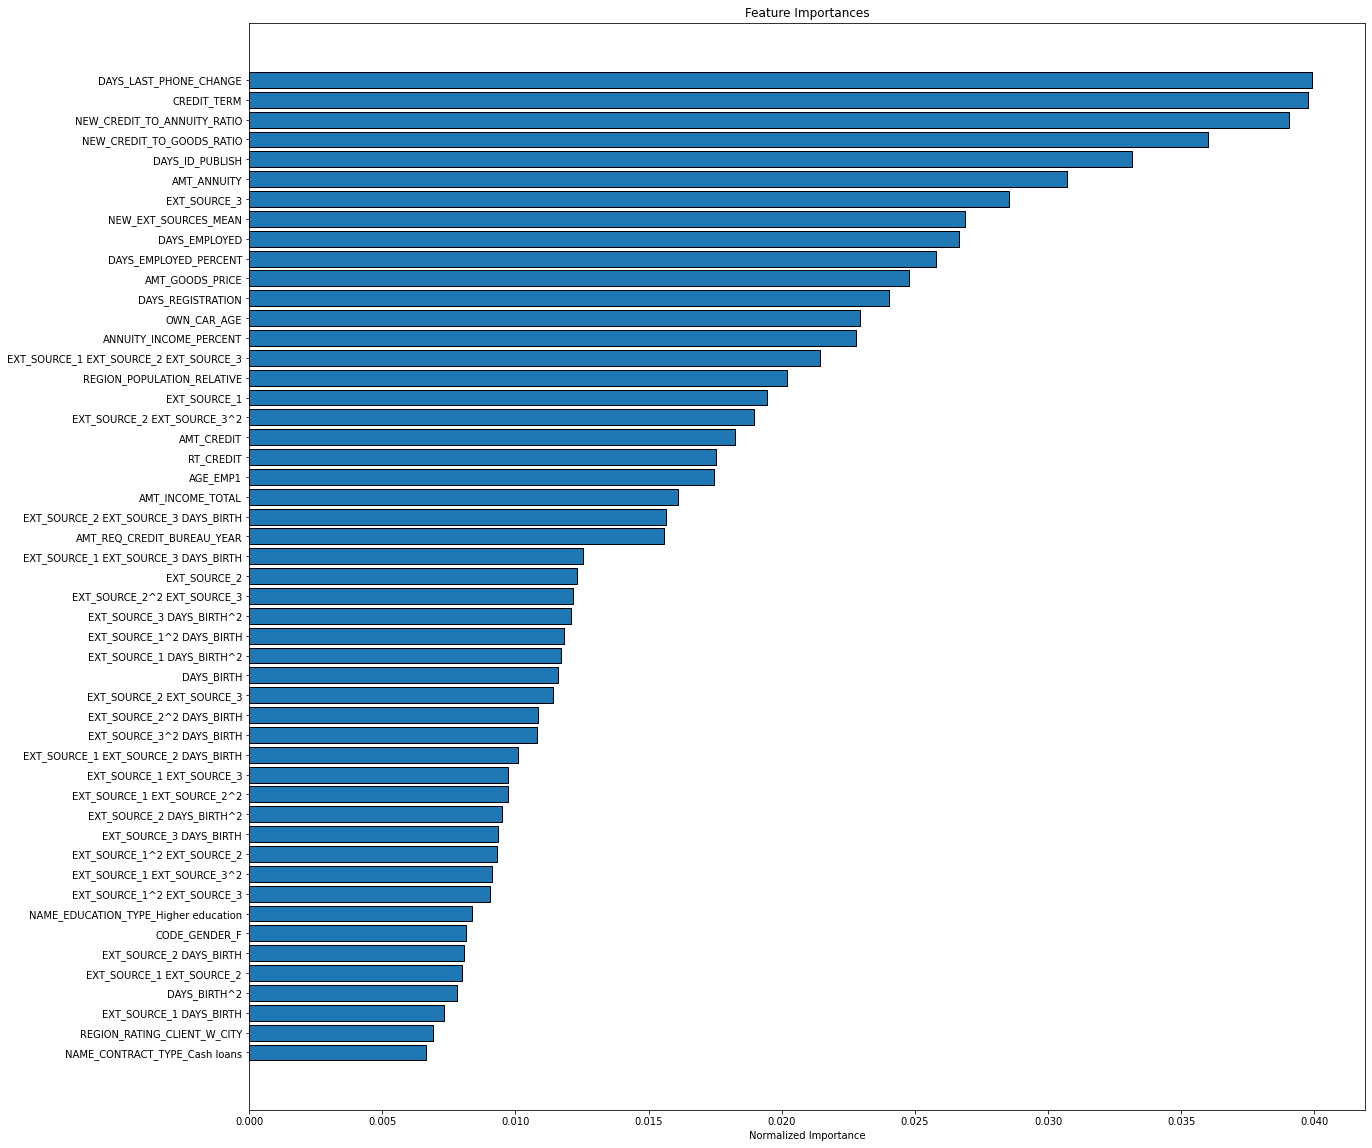

In [ ]:
fi_sorted = plot_feature_importances(fi)

In [ ]:
submission.to_csv('second_sub.csv', index = False)